In [1]:
import pandas as pd

data = pd.read_csv('job_change_train.csv')
data

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,1,Male,22,higher_BSc,science,no,county_118,162.84,1,2,18,1,<10,private_company,No
1,2,Male,27,higher_BSc,science,no,county_028,151.34,1,6,24,1,50-99,private_company,No
2,3,Male,38,higher_BSc,science,no,county_031,114.17,1,13,96,1,50-99,startup_with_funding,No
3,4,Unknown,47,higher_BSc,science,no,county_080,123.55,>4,>20,36,1,100-500,private_company,No
4,5,Male,28,higher_BSc,science,no,county_118,162.84,1,5,106,1,1000-4999,private_company,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12422,12423,Male,27,secondary,no_information,full_time,county_084,98.24,never_changed,2,34,0,unknown,no_information,Yes
12423,12424,Male,31,higher_BSc,science,no,county_059,110.45,1,7,116,1,10000+,private_company,Yes
12424,12425,Male,47,Phd,science,no,county_118,162.84,never_changed,>20,144,1,<10,private_company,No
12425,12426,Male,24,higher_BSc,science,no,county_059,110.45,never_changed,5,100,1,50-99,private_company,No


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def clean_experience(x):
    """Helper function to clean years of experience values"""
    if x == 'unknown':
        return x  # Keep unknown as its own category
    elif x == '<1':
        return 0
    elif x == '>20':
        return 21
    else:
        return float(x)

def preprocess_data(df, 
                   columns_to_encode,
                   columns_to_standardize,
                   n_most_frequent_counties=None,
                   experience_bins=None):
    """
    Preprocesses the data according to specified rules.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe to preprocess
    columns_to_encode : list
        List of column names to one-hot encode
    columns_to_standardize : list
        List of column names to standardize
    n_most_frequent_counties : int, optional
        Number of most frequent counties to keep, rest will be grouped as 'Other'
        If None, no grouping is performed
    experience_bins : dict, optional
        Dictionary mapping experience ranges to categories
        Example: {(0, 5): 'Junior', (5, 10): 'Mid', (10, float('inf')): 'Senior'}
        
    Returns:
    --------
    pandas.DataFrame
        Preprocessed dataframe
    dict
        Dictionary containing the fitted StandardScaler for each standardized column
    dict
        Dictionary containing preprocessing metadata
    """
    # Create a copy to avoid modifying the original dataframe
    df_processed = df.copy()
    
    # Handle county grouping if specified
    top_counties = None
    if n_most_frequent_counties is not None:
        county_counts = df_processed['county'].value_counts()
        top_counties = county_counts.head(n_most_frequent_counties).index.tolist()
        df_processed['county'] = df_processed['county'].apply(
            lambda x: x if x in top_counties else 'Other'
        )
    
    # Clean years of experience
    df_processed['years_of_experience_numeric'] = df_processed['years_of_experience'].apply(clean_experience)
    
    # Handle experience binning if specified
    if experience_bins:
        df_processed['years_of_experience'] = df_processed['years_of_experience_numeric'].apply(
            lambda x: 'unknown' if x == 'unknown' else next(
                (category for (low, high), category in experience_bins.items() 
                 if low <= x < high),
                'Other'  # Default category if no range matches
            )
        )
    

    # One-hot encoding
    for col in columns_to_encode:
        
        if col =='willing_to_change_job':
            df_processed[col] = df_processed[col].apply(lambda x: 1 if x=='Yes' else 0)
            continue
        # Get dummies and add prefix to avoid column name conflicts
        dummies = pd.get_dummies(df_processed[col], prefix=col,drop_first=True)
        
        # Drop the original column and join the dummy variables
        df_processed = df_processed.drop(col, axis=1)
        df_processed = pd.concat([df_processed, dummies], axis=1)
    
    # Standardization
    scalers = {}
    for col in columns_to_standardize:
        # Handle years_of_experience specially
        if col == 'years_of_experience':
            col = 'years_of_experience_numeric'
            
        scaler = StandardScaler()
        df_processed[col] = scaler.fit_transform(df_processed[[col]])
        scalers[col] = scaler
    
    # Clean up intermediate columns if not needed
    if 'years_of_experience_numeric' in df_processed.columns and \
       'years_of_experience_numeric' not in columns_to_standardize:
        df_processed = df_processed.drop('years_of_experience_numeric', axis=1)
    

    
    return df_processed, scalers

def transform_new_data(df, 
                      metadata,
                      columns_to_encode,
                      scalers):
    """
    Transforms new data using the same preprocessing steps and fitted scalers.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        New data to transform
    metadata : dict
        Dictionary containing preprocessing metadata
    columns_to_encode : list
        List of column names to one-hot encode
    scalers : dict
        Dictionary of fitted StandardScaler objects
        
    Returns:
    --------
    pandas.DataFrame
        Transformed dataframe
    """
    # Create a copy to avoid modifying the original dataframe
    df_transformed = df.copy()
    
    # Handle county grouping if it was used in training
    if metadata['top_counties'] is not None:
        df_transformed['county'] = df_transformed['county'].apply(
            lambda x: x if x in metadata['top_counties'] else 'Other'
        )
    
    # Clean years of experience
    df_transformed['years_of_experience_numeric'] = df_transformed['years_of_experience'].apply(clean_experience)
    
    # Handle experience binning if it was used in training
    if metadata['experience_bins']:
        df_transformed['experience_level'] = df_transformed['years_of_experience_numeric'].apply(
            lambda x: 'unknown' if x == 'unknown' else next(
                (category for (low, high), category in metadata['experience_bins'].items() 
                 if low <= x < high),
                'Other'  # Default category if no range matches
            )
        )
    
    # For standardization, replace string 'unknown' with median from training
    if metadata['experience_median'] is not None:
        df_transformed['years_of_experience_numeric'] = pd.to_numeric(
            df_transformed['years_of_experience_numeric'].replace('unknown', np.nan), 
            errors='coerce'
        ).fillna(metadata['experience_median'])
    
    # One-hot encoding
    for col in columns_to_encode:
        dummies = pd.get_dummies(df_transformed[col], prefix=col)
        df_transformed = df_transformed.drop(col, axis=1)
        df_transformed = pd.concat([df_transformed, dummies], axis=1)
    
    # Standardization
    for col, scaler in scalers.items():
        # Handle years_of_experience specially
        if col == 'years_of_experience':
            col = 'years_of_experience_numeric'
            
        df_transformed[col] = scaler.transform(df_transformed[[col]])
    
    # Clean up intermediate columns if not needed
    if 'years_of_experience_numeric' in df_transformed.columns and \
       'years_of_experience_numeric' not in scalers:
        df_transformed = df_transformed.drop('years_of_experience_numeric', axis=1)
    
    return df_transformed

training_data = data.drop('id', axis=1)
training_data

,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,Male,22,higher_BSc,science,no,county_118,162.84,1,2,18,1,<10,private_company,No
1,Male,27,higher_BSc,science,no,county_028,151.34,1,6,24,1,50-99,private_company,No
2,Male,38,higher_BSc,science,no,county_031,114.17,1,13,96,1,50-99,startup_with_funding,No
3,Unknown,47,higher_BSc,science,no,county_080,123.55,>4,>20,36,1,100-500,private_company,No
4,Male,28,higher_BSc,science,no,county_118,162.84,1,5,106,1,1000-4999,private_company,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12422,Male,27,secondary,no_information,full_time,county_084,98.24,never_changed,2,34,0,unknown,no_information,Yes
12423,Male,31,higher_BSc,science,no,county_059,110.45,1,7,116,1,10000+,private_company,Yes
12424,Male,47,Phd,science,no,county_118,162.84,never_changed,>20,144,1,<10,private_company,No
12425,Male,24,higher_BSc,science,no,county_059,110.45,never_changed,5,100,1,50-99,private_company,No


In [3]:

# Define preprocessing parameters
columns_to_encode = ['gender', 'education', 'field_of_studies','is_studying','county','years_since_job_change','years_of_experience','size_of_company','type_of_company','willing_to_change_job']
columns_to_standardize = ['age', 'relative_wage','hours_of_training']

# Optional parameters
n_most_frequent_counties = 10  # Set to None to keep all counties
experience_bins = {
    (0, 3): '0-3',
    (3, 7): '3-7',
    (7, 15): '7-15',
    (15, float('inf')): '15+'
}



# Preprocess training data
training_data_processed, scalers = preprocess_data(
    training_data,
    columns_to_encode= columns_to_encode,
    columns_to_standardize = columns_to_standardize,
    n_most_frequent_counties=n_most_frequent_counties,  # Optional
    experience_bins=experience_bins  # Optional
)




In [4]:
training_data_processed

,age,relative_wage,hours_of_training,is_certified,willing_to_change_job,gender_Male,gender_Other,gender_Unknown,education_higher_BSc,education_higher_MSc,...,size_of_company_500-999,size_of_company_5000-9999,size_of_company_<10,size_of_company_unknown,type_of_company_no_information,type_of_company_other,type_of_company_private_company,type_of_company_public_sector,type_of_company_startup_with_funding,type_of_company_startup_wo_funding
0,-1.328185,0.741406,-0.779442,1,0,True,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
1,-0.715787,0.217798,-0.680106,1,0,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,0.631489,-1.474594,0.511924,1,0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,1.733806,-1.047512,-0.481434,1,0,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
4,-0.593307,0.741406,0.677484,1,0,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12422,-0.715787,-2.199905,-0.514546,0,1,True,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
12423,-0.225868,-1.643970,0.843044,1,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
12424,1.733806,0.741406,1.306611,1,0,True,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
12425,-1.083226,-1.643970,0.578148,1,0,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False


In [5]:
from sklearn.model_selection import train_test_split
def clean_feature_names(X):
    """Clean feature names to be compatible with XGBoost and LightGBM"""
    if isinstance(X, pd.DataFrame):
        # Replace problematic characters in column names
        X = X.copy()
        X.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', 'lt').replace('>', 'gt') 
                    for col in X.columns]
    return X
def prepare_ml_data(df, target_col='willing_to_change_job', test_size=0.2, random_state=42):
    """
    Prepares data for ML by splitting it into features and target, then into train and test sets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Preprocessed dataframe
    target_col : str, default='willing_to_change_job'
        Name of the target column
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test)
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y  # Ensure balanced split for classification
    )
    
    return X_train, X_test, y_train, y_test

training_data_processed = clean_feature_names(training_data_processed)
# Example usage:
# Split the data
X_train, X_test, y_train, y_test = prepare_ml_data(
    training_data_processed,
    target_col='willing_to_change_job',
    test_size=0.2,
    random_state=42
)


In [6]:
X_train

,age,relative_wage,hours_of_training,is_certified,gender_Male,gender_Other,gender_Unknown,education_higher_BSc,education_higher_MSc,education_no_information,...,size_of_company_500-999,size_of_company_5000-9999,size_of_company_lt10,size_of_company_unknown,type_of_company_no_information,type_of_company_other,type_of_company_private_company,type_of_company_public_sector,type_of_company_startup_with_funding,type_of_company_startup_wo_funding
5971,-0.838266,-1.643970,-0.762886,1,False,False,True,True,False,False,...,False,False,False,False,True,False,False,False,False,False
5097,-1.328185,-1.176821,3.227103,0,False,False,True,False,False,False,...,False,False,False,True,True,False,False,False,False,False
10049,-0.225868,0.741406,-0.630438,1,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
11391,1.856285,0.789669,-0.547658,1,False,False,True,False,True,False,...,True,False,False,False,False,False,True,False,False,False
2272,-0.838266,0.741406,0.412588,1,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7886,-0.715787,-1.643970,-0.580770,0,True,False,False,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3398,-0.470828,0.741406,-1.027781,1,False,False,False,True,False,False,...,False,False,False,True,True,False,False,False,False,False
5923,-0.838266,0.556094,-0.464878,0,False,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False
9038,0.509009,0.741406,-0.514546,1,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


In [7]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
from time import time
import warnings

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=None, cv=5):
    """
    Trains a model and evaluates it using balanced accuracy score.
    
    Parameters:
    -----------
    model : sklearn estimator
        The machine learning model to evaluate
    X_train : array-like
        Training features
    X_test : array-like
        Test features
    y_train : array-like
        Training target
    y_test : array-like
        Test target
    model_name : str, optional
        Name of the model for reporting
    cv : int, default=5
        Number of cross-validation folds
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    if model_name is None:
        model_name = model.__class__.__name__
    
    results = {'model_name': model_name}
    
    # Check class distribution
    unique_classes = np.unique(y_train)
    if len(unique_classes) < 2:
        raise ValueError(f"Training data contains only one class: {unique_classes[0]}")
    
    class_counts = pd.Series(y_train).value_counts()
    results['class_distribution'] = class_counts.to_dict()
    
    # Training time measurement
    start_time = time()
    
    # Cross-validation with error handling
    try:
        # Use StratifiedKFold to ensure each fold has samples of each class
        cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        cv_scores = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='balanced_accuracy',
            return_train_score=True,
            error_score='raise'  # Raise error to catch specific CV failures
        )
        
        # Store CV results
        results['cv_results'] = {
            'train': {
                'balanced_accuracy': np.mean(cv_scores['train_score']),
                'balanced_accuracy_std': np.std(cv_scores['train_score'])
            },
            'val': {
                'balanced_accuracy': np.mean(cv_scores['test_score']),
                'balanced_accuracy_std': np.std(cv_scores['test_score'])
            }
        }
    except Exception as e:
        warnings.warn(f"Cross-validation failed: {str(e)}")
        results['cv_results'] = None
    
    # Train the model on full training data
    try:
        model.fit(X_train, y_train)
        training_time = time() - start_time
        results['training_time'] = training_time
        
        # Get predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Training set performance
        results['train_metrics'] = {
            'balanced_accuracy': balanced_accuracy_score(y_train, y_pred_train),
            'confusion_matrix': confusion_matrix(y_train, y_pred_train).tolist()
        }
        
        # Test set performance
        results['test_metrics'] = {
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_test),
            'confusion_matrix': confusion_matrix(y_test, y_pred_test).tolist()
        }
        
    except Exception as e:
        warnings.warn(f"Model training/evaluation failed: {str(e)}")
        results['train_metrics'] = None
        results['test_metrics'] = None
    
    return results

def format_results(results):
    """
    Formats the results dictionary into a readable string.
    
    Parameters:
    -----------
    results : dict
        Dictionary of results from evaluate_model
        
    Returns:
    --------
    str
        Formatted string of results
    """
    output = []
    output.append(f"Model: {results['model_name']}")
    
    # Print class distribution
    output.append("\nClass Distribution in Training Data:")
    for class_label, count in results['class_distribution'].items():
        output.append(f"Class {class_label}: {count} samples")
    
    if 'training_time' in results:
        output.append(f"\nTraining Time: {results['training_time']:.2f} seconds")
    
    # Format CV results if available
    if results['cv_results'] is not None:
        output.append("\nCross-Validation Results:")
        for split in ['train', 'val']:
            cv_results = results['cv_results'][split]
            mean = cv_results['balanced_accuracy']
            std = cv_results['balanced_accuracy_std']
            output.append(f"{split.upper()} Balanced Accuracy: {mean:.4f} (±{std:.4f})")
    
    # Format final metrics if available
    if results['train_metrics'] is not None and results['test_metrics'] is not None:
        output.append("\nFinal Metrics:")
        output.append(f"Train Balanced Accuracy: {results['train_metrics']['balanced_accuracy']:.4f}")
        output.append(f"Test Balanced Accuracy: {results['test_metrics']['balanced_accuracy']:.4f}")
        
        # Add confusion matrix
        output.append("\nTest Confusion Matrix:")
        cm = np.array(results['test_metrics']['confusion_matrix'])
        output.append(str(cm))
        
        # Calculate and add recall for each class
        recalls = np.diag(cm) / np.sum(cm, axis=1)
        for i, recall in enumerate(recalls):
            output.append(f"Recall for class {i}: {recall:.4f}")
    
    return '\n'.join(output)

In [8]:
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier, cv as xgb_cv
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
import numpy as np
import pandas as pd
from time import time

# Filter warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


def evaluate_xgboost(X_train, X_test, y_train, y_test, params, cv=5):
    """
    Specialized evaluation function for XGBoost using native CV
    """
    # Check class distribution first
    class_counts = pd.Series(y_train).value_counts()
    if len(np.unique(y_train)) < 2:
        raise ValueError(f"Training data contains only one class: {np.unique(y_train)[0]}")
    
    start_time = time()
    
    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Perform cross-validation
    cv_results = xgb_cv(
        params,
        dtrain,
        num_boost_round=200,
        nfold=cv,
        metrics=['error', 'error'],  # One for train, one for test
        early_stopping_rounds=50,
        seed=42
    )
    
    # Train final model
    model = xgb.train(params, dtrain, num_boost_round=200)
    
    # Get predictions
    y_pred_train = model.predict(dtrain)
    y_pred_test = model.predict(dtest)
    
    # Convert predictions to binary
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    
    # Calculate metrics
    train_score = balanced_accuracy_score(y_train, y_pred_train)
    test_score = balanced_accuracy_score(y_test, y_pred_test)
    cv_score_test = 1 - cv_results['test-error-mean'].iloc[-1]
    cv_score_train = 1 - cv_results['train-error-mean'].iloc[-1]
    cv_std_test = cv_results['test-error-std'].iloc[-1]
    cv_std_train = cv_results['train-error-std'].iloc[-1]
    
    training_time = time() - start_time
    
    return {
        'model_name': "XGBoost",
        'class_distribution': class_counts.to_dict(),
        'cv_results': {
            'train': {
                'balanced_accuracy': cv_score_train,
                'balanced_accuracy_std': cv_std_train
            },
            'val': {
                'balanced_accuracy': cv_score_test,
                'balanced_accuracy_std': cv_std_test
            }
        },
        'train_metrics': {
            'balanced_accuracy': train_score,
            'confusion_matrix': confusion_matrix(y_train, y_pred_train).tolist()
        },
        'test_metrics': {
            'balanced_accuracy': test_score,
            'confusion_matrix': confusion_matrix(y_test, y_pred_test).tolist()
        },
        'training_time': training_time
    }
# List of models
models = [
    (RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42
    ), "Random Forest", None),
    
    (None, "XGBoost", {
        'objective': 'binary:logistic',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'error',
        'seed': 42
    }),
    
    (GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ), "Gradient Boosting", None),
    
    (LogisticRegression(
        max_iter=1000,
        C=1.0,
        class_weight='balanced',
        random_state=42
    ), "Logistic Regression", None),
    

    
    (KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    ), "KNN", None)
]



# Store all results
all_results = {}

# Evaluate each model
for model, name, xgb_params in models:
    print(f"\nEvaluating {name}...")
    try:
        if name == "XGBoost":
            results = evaluate_xgboost(
                X_train, X_test, y_train, y_test,
                xgb_params, cv=5
            )
        else:
            results = evaluate_model(
                model, X_train, X_test, y_train, y_test,
                model_name=name, cv=5
            )
        
        results['model_name'] = name
        all_results[name] = results
        print(format_results(results))
        print("\n" + "="*80 + "\n")
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        print(f"Skipping {name} due to error")
        continue

# Create comparison dataframe
model_metrics = {}
for name, results in all_results.items():
    if results['cv_results'] and results['test_metrics']:
        model_metrics[name] = {
            'CV Score': results['cv_results']['val']['balanced_accuracy'],
            'CV Std': results['cv_results']['val']['balanced_accuracy_std'],
            'Test Score': results['test_metrics']['balanced_accuracy'],
            'Training Time (s)': results['training_time']
        }

if model_metrics:
    comparison_df = pd.DataFrame(model_metrics).T.round(4)
    comparison_df = comparison_df.sort_values('CV Score', ascending=False)



Evaluating Random Forest...
Model: Random Forest

Class Distribution in Training Data:
Class 0: 7472 samples
Class 1: 2469 samples

Training Time: 8.26 seconds

Cross-Validation Results:
TRAIN Balanced Accuracy: 0.9998 (±0.0001)
VAL Balanced Accuracy: 0.6748 (±0.0115)

Final Metrics:
Train Balanced Accuracy: 0.9995
Test Balanced Accuracy: 0.6711

Test Confusion Matrix:
[[1694  174]
 [ 349  269]]
Recall for class 0: 0.9069
Recall for class 1: 0.4353



Evaluating XGBoost...
Model: XGBoost

Class Distribution in Training Data:
Class 0: 7472 samples
Class 1: 2469 samples

Training Time: 0.83 seconds

Cross-Validation Results:
TRAIN Balanced Accuracy: 0.8391 (±0.0011)
VAL Balanced Accuracy: 0.7942 (±0.0095)

Final Metrics:
Train Balanced Accuracy: 0.8322
Test Balanced Accuracy: 0.6757

Test Confusion Matrix:
[[1648  220]
 [ 328  290]]
Recall for class 0: 0.8822
Recall for class 1: 0.4693



Evaluating Gradient Boosting...
Model: Gradient Boosting

Class Distribution in Training Data:
Clas

In [9]:
grouping_df = comparison_df.copy()
grouping_df

,CV Score,CV Std,Test Score,Training Time (s)
XGBoost,0.7942,0.0095,0.6757,0.826
Logistic Regression,0.7602,0.0103,0.7554,0.190
Gradient Boosting,0.7021,0.0023,0.6908,7.646
Random Forest,0.6748,0.0115,0.6711,8.261
KNN,0.6617,0.0100,0.6639,0.665


Top 20 Most Important Features for Predicting Job Change Likelihood:

Positive coefficients indicate higher likelihood of wanting to change jobs
Negative coefficients indicate lower likelihood of wanting to change jobs

                              Feature  Coefficient
                   county_county_074     0.966371
                   county_county_118     0.878119
                   county_county_059     0.870562
             size_of_company_unknown     0.768470
                       relative_wage    -0.736617
years_since_job_change_never_changed    -0.619777
                education_higher_BSc     0.510519
                   education_primary    -0.505713
             size_of_company_100-500    -0.502928
                   county_county_028    -0.485564
                size_of_company_lt10    -0.479267
                 education_secondary    -0.462804
                education_higher_MSc     0.426631
type_of_company_startup_with_funding    -0.404800
             size_of_company_

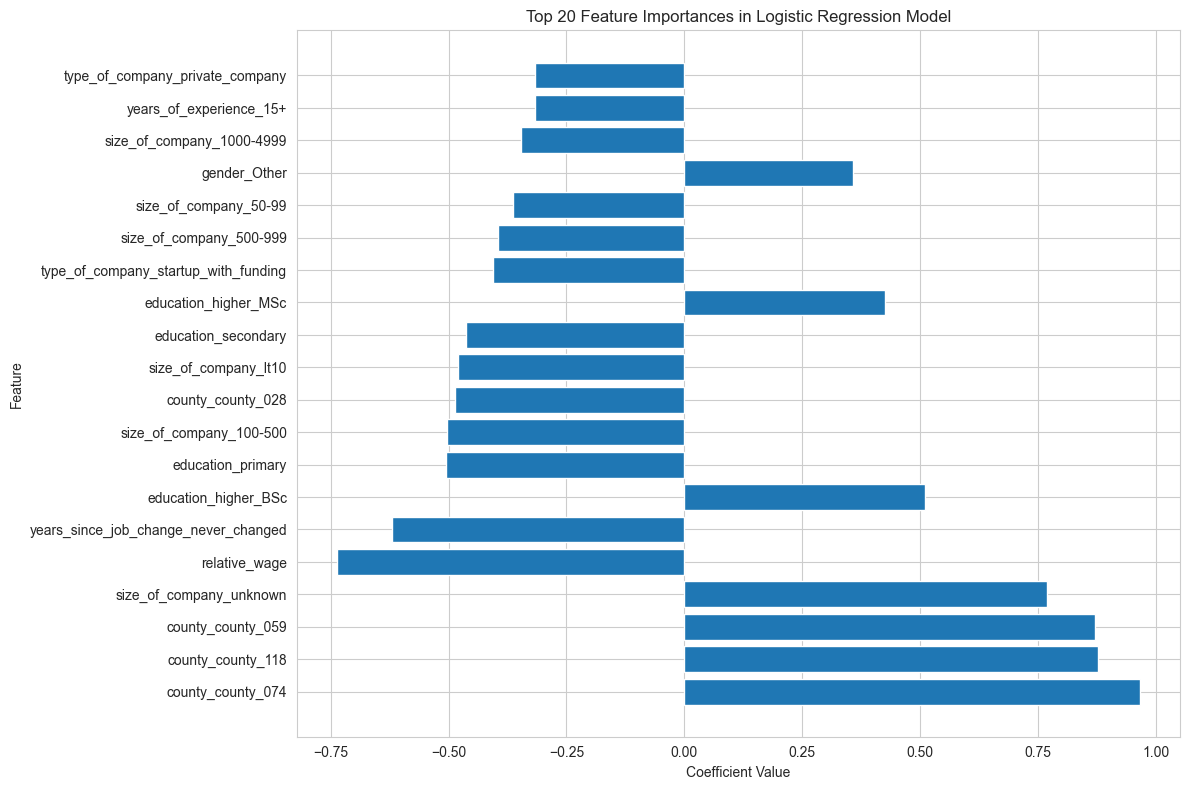

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Train the final model
final_model = LogisticRegression(
    max_iter=1000,
    penalty='l2',
    random_state=42
)

# Fit the model
final_model.fit(X_train, y_train)

# Get feature names
feature_names = X_train.columns.tolist()

# Create a dataframe with feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': final_model.coef_[0],
    'Abs_Coefficient': np.abs(final_model.coef_[0])
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Keep top 20 most important features
top_20_features = feature_importance.head(20)

# Print results
print("Top 20 Most Important Features for Predicting Job Change Likelihood:")
print("\nPositive coefficients indicate higher likelihood of wanting to change jobs")
print("Negative coefficients indicate lower likelihood of wanting to change jobs")
print("\n", top_20_features[['Feature', 'Coefficient']].to_string(index=False))

# Calculate and print model performance metrics
train_accuracy = final_model.score(X_train, y_train)
test_accuracy = final_model.score(X_test, y_test)

print("\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Create a visualization of feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'])
plt.title('Top 20 Feature Importances in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()